In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io

import torchvision.transforms as T
from PIL import Image
from torchvision.utils import make_grid
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot  as plt
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import tqdm

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    transforms.Normalize([0.5, 0.5, 0.5] , [0.5, 0.5, 0.5])
])

In [4]:
class LPDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        Blur_image_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(Blur_image_path)
        image = transformer(image)
        Main_image_path = os.path.join("DATA", "Main_image", self.annotations.iloc[index, 1])
        T_image = io.imread(Main_image_path)
        T_image = transformer(T_image)
        return (image, T_image)
    

In [5]:
# class LPDataset_val(Dataset):
#     def __init__(self, csv_file, root_dir):
#         self.annotations = pd.read_csv(csv_file)
#         self.root_dir = root_dir
        
#     def __len__(self):
#         return len(self.annotations)
    
#     def __getitem__(self, index):
#         Blur_image_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
#         image = io.imread(Blur_image_path)
#         image = transformer(image)
#         Main_image_path = os.path.join("DATA", "Main_image", self.annotations.iloc[index, 1])
#         T_image = io.imread(Main_image_path)
#         T_image = transformer(T_image)
#         return (image, T_image)
    

In [6]:
train_data = LPDataset(csv_file='ES_data.csv', root_dir='DATA/Blur')
val_data = LPDataset(csv_file='ES_data_val.csv', root_dir='DATA/Blur')

In [7]:
small_test_data = LPDataset(csv_file='test_small_data.csv', root_dir='DATA/Blur')

In [8]:
# small_test_dataloader = DataLoader(
#     small_test_data,
#     batch_size = 32,
#     shuffle= True
# )

In [9]:
train_dataloader = DataLoader(
    train_data,
    batch_size = 32,
    shuffle= True
)

In [10]:
val_dataloader = DataLoader(
    val_data,
    batch_size = 32,
    shuffle= True
)

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])


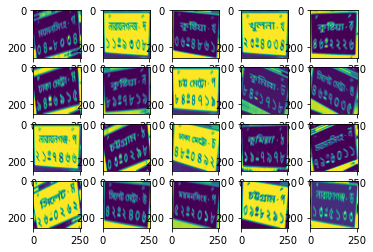

150


In [11]:
example = iter(train_dataloader)
image, T_image = example.next()
print(image.shape, T_image.shape)
for i in range(20):
    plt.subplot(4,5, i+1)
    plt.imshow(image[i][0])
plt.show()
print(len(train_dataloader))

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])


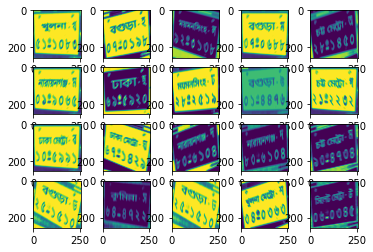

38


In [12]:
example = iter(val_dataloader)
image, T_image = example.next()
print(image.shape, T_image.shape)
for i in range(20):
    plt.subplot(4,5, i+1)
    plt.imshow(image[i][0])
plt.show()
print(len(val_dataloader))

In [13]:
class Autoencoder_03(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(3, 6, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(6, 12, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(96, 512, 4, stride=2)
            
        )
        
        
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(512, 96, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 48, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 6, 4, stride=2,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 3, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [14]:
model = Autoencoder_03()
model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
num_epochs = 100
early_stopping = 10
best_loss = float('inf')
counter = 0

train_loss_arr = []
val_loss_arr = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for (_,[image, T_image]) in enumerate(train_dataloader):

        image = image.to(device)
        T_image = T_image.to(device)
        
        out = model(image)
        loss = criterion(out, T_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss +=loss.cpu().data
    train_loss /= len(train_dataloader)  
    train_loss_arr.append(train_loss)

    model.eval()
    val_loss = 0
    for (_, [image, T_image]) in enumerate(val_dataloader):

        image = image.to(device)
        T_image = T_image.to(device)
        
        out = model(image)
        v_loss = criterion(out, T_image)
        val_loss +=v_loss.cpu().data
    val_loss /= len(val_dataloader)  
    val_loss_arr.append(val_loss)
    
    print(f'Epoch {epoch+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}')
    if epoch > 19:
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
            # Save the best model

            torch.save(model.state_dict(), 'best_model_stat/best_model.pt')
        else:
            counter += 1

        # Stop the training if the stopping criterion is met
        if counter >= early_stopping:
            print(f'Early stopping at epoch {epoch+1}')
            break
            
model.load_state_dict(torch.load('best_model_stat/best_model.pt'))

Epoch 1: train loss = 0.5141, val loss = 0.4903
Epoch 2: train loss = 0.4897, val loss = 0.4732
Epoch 3: train loss = 0.4758, val loss = 0.4616
Epoch 4: train loss = 0.4660, val loss = 0.4543
Epoch 5: train loss = 0.4582, val loss = 0.4476
Epoch 6: train loss = 0.4515, val loss = 0.4413
Epoch 7: train loss = 0.4461, val loss = 0.4367
Epoch 8: train loss = 0.4412, val loss = 0.4326
Epoch 9: train loss = 0.4371, val loss = 0.4302
Epoch 10: train loss = 0.4333, val loss = 0.4260
Epoch 11: train loss = 0.4289, val loss = 0.4143
Epoch 12: train loss = 0.4166, val loss = 0.4095
Epoch 13: train loss = 0.4135, val loss = 0.4084
Epoch 14: train loss = 0.4114, val loss = 0.4068
Epoch 15: train loss = 0.4099, val loss = 0.4044
Epoch 16: train loss = 0.4082, val loss = 0.4027
Epoch 17: train loss = 0.4068, val loss = 0.4028
Epoch 18: train loss = 0.4059, val loss = 0.4018
Epoch 19: train loss = 0.4042, val loss = 0.3995
Epoch 20: train loss = 0.4019, val loss = 0.3967
Epoch 21: train loss = 0.3986

<All keys matched successfully>

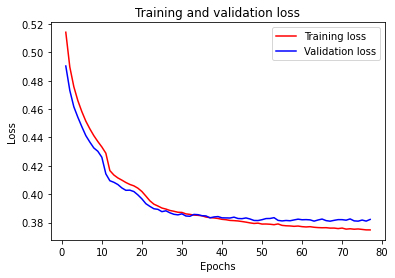

In [23]:
plt.plot(range(1, 78), train_loss_arr, 'r', label='Training loss')
plt.plot(range(1, 78), val_loss_arr, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

# epoch = [12, 12,23,345]
# sum = 0
# print_screen = tqdm(list(epoch))
# for i in print_screen:
#     print_screen.set_description("holadfgdfg hsd sfg sdf gsfg s df gsdf gsfg gh fg d ")

In [32]:
def PredictionCNN(image_path , transformer):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor.to(device)
       
        
    input = Variable(image_tensor).to(device)

    output = model(input)
    output = output.cpu()
    
    
    plt.imshow(output[0].permute(1, 2, 0).detach().numpy())
    plt.show()
    
    return output.size()

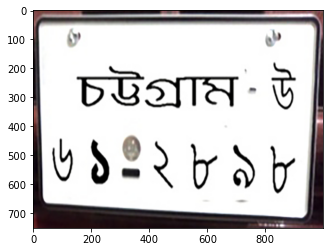

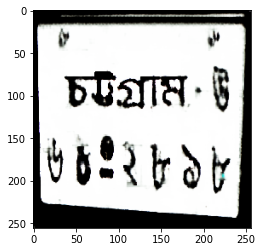

torch.Size([1, 3, 256, 256])

In [33]:
PredictionCNN("G:/CSE_499a/jupyter/DeBlur/try01/0_136.jpg", transformer)

In [28]:
model04 = Autoencoder_03()
model04 = model04.to(device)

model04.load_state_dict(torch.load('best_model_stat/best_model.pt'))
model04.eval()

Autoencoder_03(
  (encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(6, 12, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2))
    (9): ReLU()
    (10): Conv2d(96, 512, kernel_size=(4, 4), stride=(2, 2))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 96, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(96, 48, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): ConvTranspose2d(12, 6, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
    (9): ReLU()
    (10): ConvTranspose2d(6, 3, kernel_size=(4, 4), st

In [ ]:
# torch.cuda.empty_cache()